<a href="https://colab.research.google.com/github/ENGS-108-Fall-23/Assignment_2_Main/blob/main/assignment_2_Fall2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ENGS 108 Fall 2023 Assignment 2**

*Due TBD at 11:59PM on Github*

**Instructors:** George Cybenko

**TAs:** Ganesh Rohit Nirogi, Diksha Bubna, Sunishka Jain, Kushagra Rawat


---

## **Rules and Requirements**


1.   You are only allowed to use Python packages that are explicity imported in 
the assignment notebook or are standard (bultin) python libraries like random, os, sys, etc, (Standard Bultin Python libraries will have a Python.org documentation). For this assignment you may use:
  *   [numpy](https://numpy.org/doc/stable/)
  *   [pandas](https://pandas.pydata.org/pandas-docs/stable/index.html)
  *   [scikit-learn](https://scikit-learn.org/stable/)
  *   [matplotlib](https://matplotlib.org/)

2.   All code must be fit into the designated code or text blocks in the assignment notebook. They are indentified by a **TODO** qualifier.

3. For analytical questions that don't require code, type your answer cleanly in Markdown. For help, see the [Google Colab Markdown Guide](https://colab.research.google.com/notebooks/markdown_guide.ipynb).

---


In [201]:
''' Import Statements '''
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn.linear_model import LinearRegression
from scipy import signal
import matplotlib.collections as collections


# **Data Loading**
Upload the red and synthetic datasets to your google colab session using Google Drive. Read the following [tutorial](https://github.com/Thayer-ENGS108/Assignment_2_Fall2022) for how to get setup. 

In [202]:
# DONE: Set your base datasets path. This is my base path, you will need to change to match yours. 
dataset_base_path = 'datasets/'

In [203]:
#-- Everything else you should not need to change.
import os
import pickle

#-- Gather paths
synth_data_path = os.path.join(dataset_base_path, 'assign_2_synth_data.pk')
red_train_path = os.path.join(dataset_base_path, 'red_train.csv')
red_valid_path = os.path.join(dataset_base_path, 'red_valid.csv')
red_test_path = os.path.join(dataset_base_path, 'red_test.csv')
synth_train_path = os.path.join(dataset_base_path, 'synth_train.csv')
synth_valid_path = os.path.join(dataset_base_path, 'synth_valid.csv')
synth_test_path = os.path.join(dataset_base_path, 'synth_test.csv')

#-- Load Synth_Data
with open(synth_data_path, 'rb') as f_:
  synth_data = pickle.load(f_)

#-- Load Red Wine Data
red_train_df = pd.read_csv(red_train_path)
red_valid_df = pd.read_csv(red_valid_path)
red_test_df = pd.read_csv(red_test_path)
synth_train_df = pd.read_csv(synth_train_path)
synth_valid_df = pd.read_csv(synth_valid_path)
synth_test_df = pd.read_csv(synth_test_path)

#-- Data is stored in a tuple of format (X, y) and are already converted to numpy arrays.
red_train = (red_train_df.drop('quality', axis=1).to_numpy(), red_train_df['quality'].to_numpy())
red_valid = (red_valid_df.drop('quality', axis=1).to_numpy(), red_valid_df['quality'].to_numpy())
red_test = (red_test_df.drop('quality', axis=1).to_numpy(), red_test_df['quality'].to_numpy())

#-- Load in Synth train, valid, test data with tuple format (X, y)
synth_train = (synth_train_df.drop('y', axis=1).to_numpy(), synth_train_df['y'].to_numpy())
synth_valid = (synth_valid_df.drop('y', axis=1).to_numpy(), synth_valid_df['y'].to_numpy())
synth_test = (synth_test_df.drop('y', axis=1).to_numpy(), synth_test_df['y'].to_numpy())

## **Problem 1: $K$-Means Clustering**
In this problem, you will solve a clustering
task using the k-means algorithm and an associated classification task using $k$ nearest neighbors algorithm, both of which you learned in class. The dataset for this problem is a synthetic two-dimensional dataset *synth_data*. Each entry has two features $(x_1, x_2)$.
>
> **Part 1** A reasonable first step in every machine learning task is to understand the dataset at hand. Proceed to explore this problem’s dataset by addressing the following:
>> **(a)** Choose a suitable type of plot and visualize the training data.

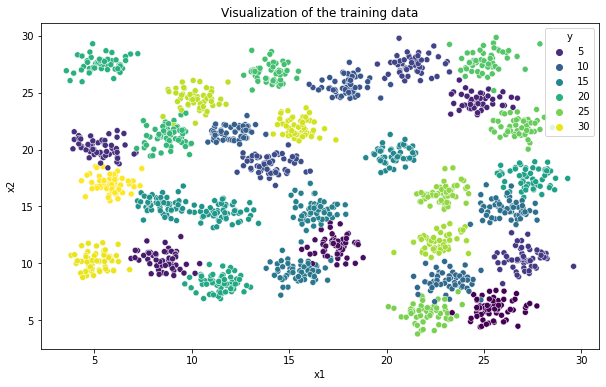

In [204]:
# DONE: Write your code here. Use matplotlib for visualization.
import seaborn as sns
import matplotlib.pyplot as plt

# Extract the features from the synth_train dataset
X, y = synth_train

# Convert the features into a DataFrame for easier manipulation
df = pd.DataFrame(X, columns=['x1', 'x2'])

# Add the target variable to the DataFrame
df['y'] = y

# Use seaborn's scatterplot function to visualize the data
plt.figure(figsize=(10, 6))
sns.scatterplot(x='x1', y='x2', hue='y', data=df, palette='viridis')
plt.title('Visualization of the training data')
plt.show()

>> **(b)** From your plot, how many clusters, $k$, would you estimate are represented in the dataset?

Given this plot, I would estimate that there are about 32 distinct clusters in the dataset. These clusters are quite clearly grouped together in the plot above, and colored differently. However, some are overlapping, so the number of clusters could be between 20-40. 

> **Part 2** Build a model.
>> **(a)** Using the k-Means algorithm, implement a clustering model. *Hint: Use [scikit-learn's K-means library](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).*

In [205]:
# DONE: Just define a model, don't train yet.
from sklearn.cluster import KMeans

# define the k-means model for this specific dataset
kmeans = KMeans(n_clusters=32, random_state=0, init='k-means++')

In [206]:
# EXTRA: a custom implementation of the k-means algorithm
class KMeansCustom:
    def __init__(self, n_clusters=32, max_iter=300, random_state=0):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        
    def fit(self, X):
        np.random.seed(self.random_state)
        # randomly initialize centroids
        self.centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]
        for _ in range(self.max_iter):
            # assign each data point to the closest centroid
            self.labels_ = np.argmin(np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2), axis=1)
            # update centroids to be the mean of assigned points
            new_centroids = np.array([X[self.labels_ == i].mean(axis=0) for i in range(self.n_clusters)])
            # if centroids haven't changed, we have converged
            if np.all(new_centroids == self.centroids):
                break
            else:
                self.centroids = new_centroids
        return self

kmeans_custom = KMeansCustom()

>> **(b)** Train the clustering model on several reasonable values of $k$, taking into account your visual inspection from 1b. Plot the sum of distance (SSE) from each data point and its respective cluster for 10 different values of $k$.

In [207]:
def train(k, dataset):
  ''' Using your model above, implement a function that will train your K-means
  for different values of k on your dataset and return the trained model'''
  
  # train the model for current value of k on training data
  model = KMeans(n_clusters = k, random_state = 0, init='k-means++')
  model.fit(dataset)
  
  return model
    

In [208]:
from sklearn.metrics import mean_squared_error
def calculateSSE(model):
  ''' Using a trained model calculate the SSE for the model '''
  # use built-in sum of squared errors from kmeans object 
  sse = model.inertia_ 

  return sse

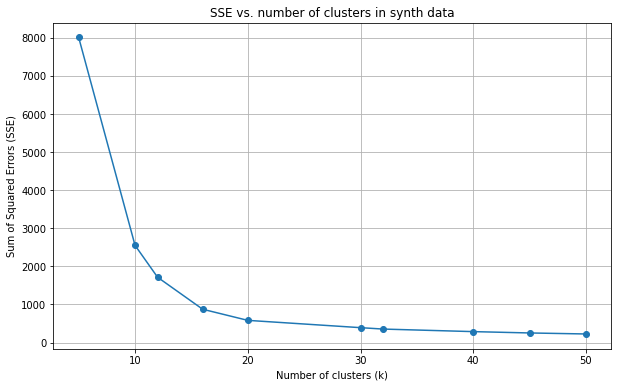

In [209]:
# DONE: Choose 10 different values of k based on your inspection and plot the SSE scores.
k_values = [5, 10, 12, 16, 20, 30, 32, 40, 45, 50]
sse_values = []

# loop through the list of values to train a kmeans model for each
for k in k_values:
    model = train(k, synth_data)
    sse = calculateSSE(model)
    sse_values.append(sse)
    
plt.figure(figsize=(10, 6))
plt.plot(k_values, sse_values, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('SSE vs. number of clusters in synth data')
plt.grid(True)
plt.show()

>> **(c)** What value of $k$ is optimal? How does it compare to your visual inspection?



The optimal value of K is the one that minimizes the Sum of Squared Errors (SSE). From the graph plotted above, we can observe that as the number of clusters (K) increases, the SSE decreases exponentially. This is because when the number of clusters is increased, each point becomes closer to the centroid of its cluster, so the SSE decreases.

But we can't keep increasing the number of clusters indefinitely. At some point, the decrease in SSE becomes negligible or very small - the elbow point. In this graph, it looks like the elbow point is at about k=16, where SSE=~1000. After this point, there are very diminishing returns to more clusters. 

This is substantially fewer than my visual inspection. Based on the graph, I expected there to be at least 20 and most likely around 30 clusters, but it turns out fewer is more optimal - especially to avoid overfitting. Of course, k=30 is slightly lower MSE than k=16, but only by a small amount. 

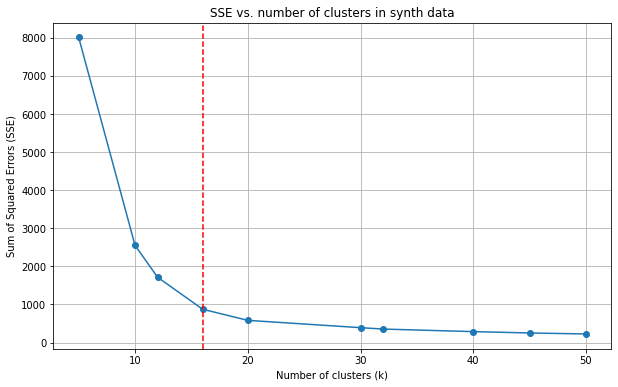

In [210]:
#TODO: Write code and plot a graph showing the optimal value of k.
# use the KneeLocator function to detect the elbow point
kl = KneeLocator(k_values, sse_values, curve="convex", direction="decreasing")

# kl.elbow will give the optimal value of k (defined as elbow point)
optimal_k = kl.elbow

# plot the graph
plt.figure(figsize=(10, 6))
plt.plot(k_values, sse_values, marker='o')
plt.axvline(x=optimal_k, color='r', linestyle='--')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('SSE vs. number of clusters in synth data')
plt.grid(True)
plt.show()

# **Problem 2: $k$-NN Classification**
In this problem, you will utilize data deriving
from the same synthetic dataset as above. This time, the data has been separated into *synth_train*, *synth_valid* and *synth_test* arrays. Furthermore, each sample now includes a class label found in the $y$ column. These class labels come from the set $\{1, 2, . . . , 31\}$. *Note: These are not the same datasets as Problem 1.* 

> **Part 1** Train an implementation of the $k$-Nearest Neighbors algorithm on the training dataset. Note that $k$ here refers to the number of neighbors, not clusters.

In [211]:
from sklearn.neighbors import KNeighborsClassifier

def train(k, dataset):
  ''' Implement a function that will train a k-NN
  for different values of k on your dataset and return the trained model'''

  # Initialize the KNeighborsClassifier with the value of k
  model = KNeighborsClassifier(n_neighbors=k)

  # Fit the model with the dataset
  X, y = synth_train
  model.fit(X, y)
  return model

> **Part 2** Report the classification accuracy of this model on the validation set for different values for $k$. Plot these accuracies against $k$ and report the optimal value for $k$.

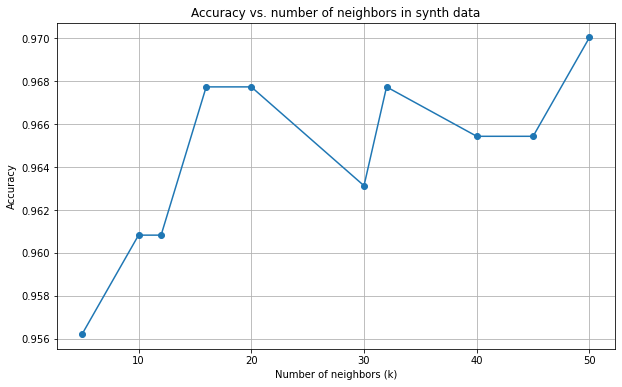

The optimal value for k (highest accuracy) is 50 with an accuracy of 97%


In [212]:
# DONE
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

k_values = [5, 10, 12, 16, 20, 30, 32, 40, 45, 50]
accuracy_values = []

for k in k_values:
    model = train(k, synth_train)
    valid_X, valid_y = synth_valid
    predictions = model.predict(valid_X)  
    accuracy = accuracy_score(valid_y, predictions)
    accuracy_values.append(accuracy)

plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracy_values, marker='o')
plt.xlabel('Number of neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. number of neighbors in synth data')
plt.grid(True)
plt.show()

optimal_k = k_values[accuracy_values.index(max(accuracy_values))]
optimal_accuracy = round(max(accuracy_values) * 100)
print(f"The optimal value for k (highest accuracy) is {optimal_k} with an accuracy of {optimal_accuracy}%")

> **Part 3** Report the classification precision, recall and F1-score of this model on the data in synth test.csv using the optimal value of $k$ that you found in Part 2.

In [213]:
# DONE 
from sklearn.metrics import precision_score, recall_score, f1_score

# use the optimal k value to train the model 
model = train(optimal_k, synth_train)

# evaluate the model by predicting on test data
test_X, test_y = synth_test
predictions = model.predict(test_X)

# calculate precision, recall, and f1 score (averaged by unweighted mean)
precision = precision_score(test_y, predictions, average='macro')
recall = recall_score(test_y, predictions, average='macro')
f1 = f1_score(test_y, predictions, average='macro')

# print the results
print(f"Precision: {round(100 * precision, 3)}%")
print(f"Recall: {round(100 * recall, 3)}%")
print(f"F1 Score: {round(100 * f1, 3)}%")

Precision: 97.532%
Recall: 97.505%
F1 Score: 97.486%


**Results interpretation**
* Precision = ratio of correctly predicted positives / total positives. When this model predicts a class, it's correct 97.5% of the time - it gets most of the right answers. 
* Recall = ratio of correctly predicted positives / all observations - 0.975%, extremely low low. 
* F1 score = weighted average of precision & recall, takes false positives into account. 

# **Problem 3: Decision Tree Classification**
In this problem you will use decision
trees to classify the quality of red vinho verde wine samples based on their physicochemical properties. The dataset has been separated into *red_train, red_valid and red_test* arrays. For all of these files, the rightmost column (“quality”) is the target label for each datapoint. All other columns are features.

> **Part 1** First let’s explore the datasets through the following exercises. Note that we cannot plot the data in a meaningful way given that number of features exceed the physical dimensions.

>> **(a)** How many datapoints are in the training, validation, and testing sets?

In [214]:
# DONE
# calculate the number of datapoints in each dataset
# for each dataset, we sum the lengths of the two arrays in the tuple
print(f"Number of datapoints in the training set: {len(red_train[0]) + len(red_train[1])}")
print(f"Number of datapoints in the validation set: {len(red_valid[0]) + len(red_valid[1])}")
print(f"Number of datapoints in the testing set: {len(red_test[0]) + len(red_test[1])}")

Number of datapoints in the training set: 1790
Number of datapoints in the validation set: 448
Number of datapoints in the testing set: 960


There are 1790 datapoints (individual observations/instances) in the training set, 448 in the validation, and 960 in the testing set. This includes both the features and labels. 

There are 10 feature columns (properties of red wine), and 1 label column (quality). 

>> **(b)** How many features are available for each datapoint?

In [215]:
# DONE
# get the features from the training set
features = red_train[0][:, :-1]  # drop the last column (the label)

# print the number of features
print(f"Number of features: {features.shape[1]}, datapoints per feature: {features.shape[0]}")
print(f"Feature names: {red_train_df.columns.values}")

Number of features: 10, datapoints per feature: 895
Feature names: ['fixed acidity' 'volatile acidity' 'citric acid' 'residual sugar'
 'chlorides' 'free sulfur dioxide' 'total sulfur dioxide' 'density' 'pH'
 'sulphates' 'alcohol' 'quality']


>> **(c)** What are the average *alcohol* and *pH* values for *training* samples?

In [216]:
 # calculate the average alcohol and pH values using pandas mean() function
 print(f"Average alcohol value: {red_train_df['alcohol'].mean()}")
 print(f"Average pH value: {red_train_df['pH'].mean()}")


Average alcohol value: 10.397951582867744
Average pH value: 3.309541899441341


Mean alcohol content across all samples in the dataset is approximately 10.40%, while average pH value of 3.31 indicates that the mean pH level of the wines is fairly acidic. 

> **Part 2** Decision Trees.

>> **(a)** Implement a binary decision tree model for the training data. *Hint: Try looking at the [scikit-learn decision tree library](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decision%20tree#sklearn.tree.DecisionTreeClassifier).*

In [217]:
from sklearn.tree import DecisionTreeClassifier
def train(dataset, max_depth=None):
  ''' Implement a function that will train a decision tree model
  on your dataset and return the trained model'''
  
  # separate the features and the labels
  X = dataset[0]
  y = dataset[1]
  
  # create a decision tree classifier
  model = DecisionTreeClassifier(max_depth=max_depth)
  
  # train the model
  model.fit(X, y)
  return model

>> **(b)** There are a number of hyperparameters that can be tuned to improve your model, one of which is the criteria for ending the splitting process. Two common ways of terminating the splitting process are *maximum depth* of the tree or *minimum number of samples* left. Tune the *maximum depth* of the tree by reporting the accuracy of the classifier in 2a on the validation set for different settings of *maximum depth*. Plot your findings.

Max Depth: 1, Accuracy: 0.5535714285714286
Max Depth: 2, Accuracy: 0.5401785714285714
Max Depth: 3, Accuracy: 0.5758928571428571
Max Depth: 4, Accuracy: 0.5892857142857143
Max Depth: 5, Accuracy: 0.5982142857142857
Max Depth: 6, Accuracy: 0.5669642857142857
Max Depth: 7, Accuracy: 0.5401785714285714
Max Depth: 8, Accuracy: 0.5803571428571429
Max Depth: 9, Accuracy: 0.5669642857142857
Max Depth: 10, Accuracy: 0.5758928571428571
Max Depth: 11, Accuracy: 0.5491071428571429
Max Depth: 12, Accuracy: 0.59375
Max Depth: 13, Accuracy: 0.59375
Max Depth: 14, Accuracy: 0.6116071428571429
Max Depth: 15, Accuracy: 0.5803571428571429
Max Depth: 16, Accuracy: 0.5758928571428571
Max Depth: 17, Accuracy: 0.5848214285714286
Max Depth: 18, Accuracy: 0.5535714285714286
Max Depth: 19, Accuracy: 0.5535714285714286
Max Depth: 20, Accuracy: 0.5803571428571429
Max Depth: 21, Accuracy: 0.5982142857142857
Max Depth: 22, Accuracy: 0.5758928571428571
Max Depth: 23, Accuracy: 0.5714285714285714
Max Depth: 24, Accu

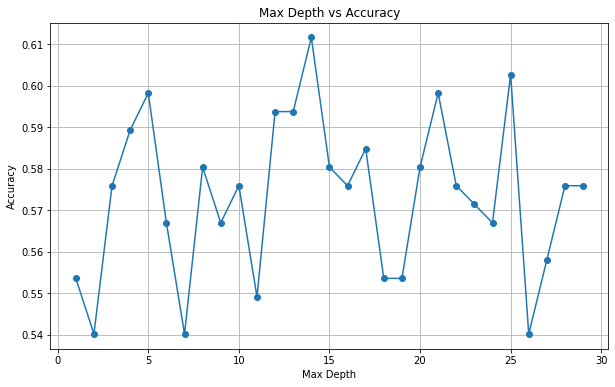

In [218]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

# define the range of max_depth values to be searched
max_depth_values = list(range(1, 30))

accuracy_scores = [] # store accuracy scores for each max_depth value

# loop over the max_depth_values
for max_depth in max_depth_values:
    # train the decision tree model with the current max_depth value
    model = train(red_train, max_depth)

    # make predictions on the validation set
    predictions = model.predict(red_val_X)

    # calculate the accuracy score and append it to the accuracy_scores list
    score = accuracy_score(red_val_y, predictions)
    accuracy_scores.append(score)

# create a dictionary to store the results
results = {'max_depth': max_depth_values, 'accuracy_score': accuracy_scores}

# print the accuracy for each max_depth value
for depth, score in zip(max_depth_values, results['accuracy_score']):
    print(f"Max Depth: {depth}, Accuracy: {score}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, results['accuracy_score'], marker='o')
plt.title('Max Depth vs Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

>> **(c)** Use the optimum setting of *maximum depth* found in 2b to report the accuracy of the classifier on the *test* dataset.

In [219]:
    # find the index of the maximum accuracy score
    max_accuracy_index = results['accuracy_score'].index(max(results['accuracy_score']))
    optimal_max_depth = results['max_depth'][max_accuracy_index]
    
    # print the max depth and corresponding accuracy score
    print(f"Optimal Max Depth: {optimal_max_depth}, Accuracy: {max(results['accuracy_score'])*100}%")

Optimal Max Depth: 14, Accuracy: 61.16071428571429%


# **Problem 4: Systems - Estimating ODE Parameters**

Many real-world systems can be modelled by linear diffferential equations. Some of the most common examples are mechanical and electrical oscillations (see mass-spring example below) which can be described by the solution of an initial value problem of the form:

$$𝑎𝑥″+𝑏𝑥′+𝑐𝑥=𝑔(𝑡)  \tag{1}$$    

, where initial condition are given by:       $𝑥(0)=𝑥0$,   $𝑥′(0)=𝑥′0$                    
 
For our problems, we will assume that $g(t) = 0$, no external force (for spring system etc)

![Url](https://benmoseley.blog/wp-content/uploads/2021/08/oscillator.gif)


>**Part 1** Lets generate some synthetic data using an ODE for a vibration with no damping in chapter 3.7 Example 4 (Source: Elementary Differential Equations and Boundary Value Problems by Boyce & DiPrima, Wiley 2017).
In this system, $$ x'' + 0.125x' + x= 0 \tag{2}$$ 
and the analytical solution is the function below:


In [220]:
t = np.linspace(0, 30*np.pi, 1000)   # time
x_funct = lambda t: (32/np.sqrt(255))*np.exp(-1*t/16)*np.cos((np.sqrt(255)/16)*t -0.06254)  # function to get x given t

# analytic function x given t 
x_analytic = x_funct(t)

>> **(a)** Now lets assume we have observed a noisy sample composed of the first 20% of x_analytic. Create noisy data for the first 20% of x_analytic

In [221]:
# create t_noisy (time) to record time for the first 20% of t 
NOISY_FACTOR = 5 # controls the threshold for adding noise

len_t = int(0.2*len(t))
t_noisy = t[:len_t]

In [222]:
# DONE: Compute x for the corresponding t_noisy
x = x_funct(t_noisy)

In [223]:
# DONE: adding noise
noise = np.array(np.random.random(len_t) - 0.5)/NOISY_FACTOR
x_noisy = x + noise

>>**(b)** Our task in this question is to estimate parameters a, b, and c, assuming that we only observed x_noisy

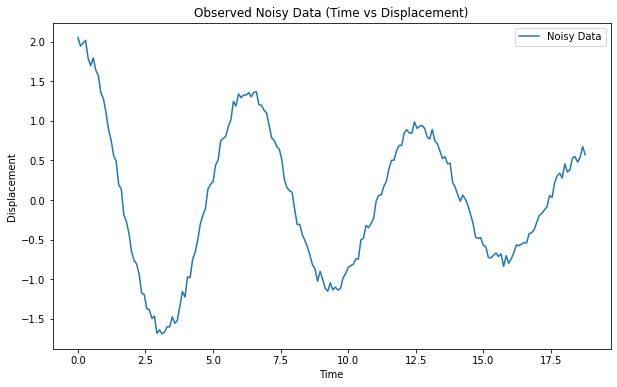

In [224]:
# DONE: Plot the observed noisy data below (time vs displacement)

# plot the noisy data
plt.figure(figsize=(10,6))
plt.plot(t_noisy, x_noisy, label='Noisy Data')
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.title('Observed Noisy Data (Time vs Displacement)')
plt.legend()
plt.show()

>> **(c)** Real-world data is often noisy and denoising can help to reduce the noise. Denoise the above data to create x_denoised:

In [225]:
# denoising
N, Wn = 5, 0.03   # Feel free to modify N and Wn as you see fit!
b, a = signal.butter(N, Wn, analog=False)   # module from scipy
x_denoised = signal.filtfilt(b,a,x_noisy)

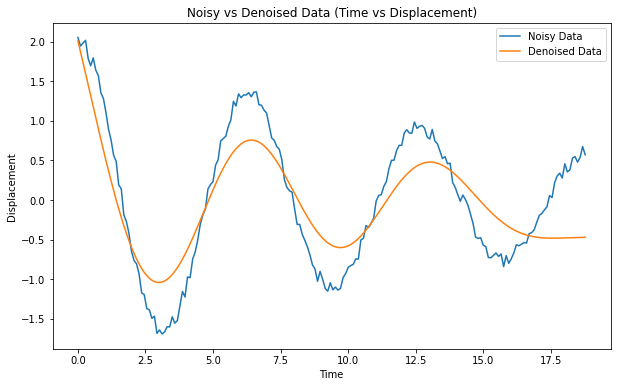

In [226]:
# DONE: Plot and insert legend to differentiate x_noisy and x_denoised vs time (on same plot)
plt.figure(figsize=(10,6))
plt.plot(t_noisy, x_noisy, label='Noisy Data')
plt.plot(t_noisy, x_denoised, label='Denoised Data')
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.title('Noisy vs Denoised Data (Time vs Displacement)')
plt.legend()
plt.show()


**Part 2**: Compute derivatives x' and x'' to estimate a, b, and c given x

>>**a** Using the ([forward method (finite difference)](https://en.wikipedia.org/wiki/Finite_difference)).
compute $x'$ and $x''$ for both x_noisy and x_denoised

In [227]:
# DONE: Complete the function below
def first_derivative(X, dt):
    # approximate derivative using forward nethod 
    # create an empty array of zeros, same length as X
    first_derivative = np.zeros(len(X))
    # iterate over X, except the last element
    for i in range(len(X)-1):
        # calculate the difference between the next and the current element, divided by dt
        first_derivative[i] = (X[i+1] - X[i]) / dt
    # for the last element, use the same value as for the second to last element
    first_derivative[-1] = first_derivative[-2]
    return first_derivative

In [228]:
# DONE: Complete the functions below
def second_derivative(X_first, dt):
    # Basically differentiate the first derivative
    # create an empty array of zeros, same length as X_first
    second_derivative = np.zeros(len(X_first))
    # iterate over X_first, except the last element
    for i in range(len(X_first)-1):
        # calculate the difference between the next and the current element, divided by dt
        second_derivative[i] = (X_first[i+1] - X_first[i]) / dt
    # for the last element, use the same value as for the second to last element
    second_derivative[-1] = second_derivative[-2]
    return second_derivative

In [249]:
def get_derivatives(X):
    dt = t[1] - t[0] # time difference
    X_prime =  first_derivative(deepcopy(X), dt)
    X_prime_squared = second_derivative(deepcopy(X_prime), dt) 
    return X, X_prime, X_prime_squared
    
# for noisy data 
x, x_prime, x_prime_squared = get_derivatives(x_noisy)

# for denoised data
x1, x_prime1, x_prime_squared1 = get_derivatives(x_denoised)

PLOT FOR DENOISED DATA


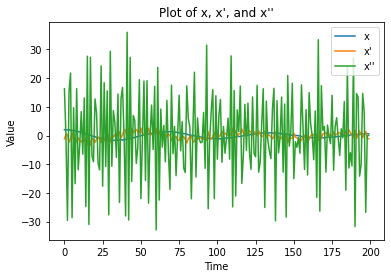

PLOT FOR NOISY DATA


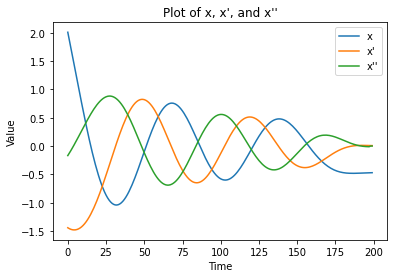

In [250]:
# DONE: Fill the function below
def plot_figs (x, x_first, x_second):
    # adding titles and labels for better understanding of the plots
    # create a new figure and axis
    fig, ax = plt.subplots()
    
    # plot x, x', x'' on the same graph
    ax.plot(x, label='x')
    ax.plot(x_first, label="x'")
    ax.plot(x_second, label='x\'\'')
    
    # add a legend to explain which line is which
    ax.legend()
    
    # adding title and labels for the plot
    ax.set_title('Plot of x, x\', and x\'\'')
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    
    # show the plot
    plt.show()

print(f"PLOT FOR DENOISED DATA")
plot_figs(x, x_prime, x_prime_squared)
print(f"PLOT FOR NOISY DATA")
plot_figs(x1, x_prime1, x_prime_squared1)

>>**(b)** How do the derivative plots compare for the noisy vs the denoised samples? Whats the effect of denoising? What happens when we adjust the NOISY_FACTOR (see Part 1a)?

- The first derivative plot (x') is the rate of change of the function (velocity), while the second derivative plot (x'') represents the acceleration of the vibration with no damping. 
- For the noisy data, the plots of x', and x'' have much more fluctuations - the noise amplifies the difference. 
- After denoising, the plots of x', and x'' are much smoother as the noise has been reduced. This makes it easier to observe the underlying trends in the data. 
- Adjusting the NOISY_FACTOR affects the amount of noise in the data - increasing it will increase fluctuations in the plots plots due to more underlying noise, especially for the derivatives. Decreasing the NOISY_FACTOR will make the data less noisy and the plots smoother. Too much denoising can remove information, but it makes the plots easier to read. 


>>**(c)** Now we have x, x' and x''. Since g(t) = 0; we can estimate a, b, and c via regression. If we assume c = 1, 
then Equation 1 can be written as:
    
    
$$𝑎𝑥″+𝑏𝑥′ =  -x \tag{3}$$


>>>From Equation 3, we can perform [linear regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) to estimate parameters a and b. Using -x as your dependent variable, and x' and x'' as your independent variables. Train a regression model below:




In [251]:
from sklearn.linear_model import LinearRegression

def train_model(X, X_first, X_second):
    """
    X - original x, X_first - first derivative, X_second - second derivative 
    """
    
    # adjust the size of the arrays to match
    X_first = X_first[:len(X_second[:-3])]
    
    # create a 2d array of the first and second derivatives
    X_train = np.column_stack((X_first, X_second[:-3]))
    
    # create the dependent variable array
    y_train = -X[:len(X_train)]
    
    # initialize and fit the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # return the regression coefficients and the model
    return model.coef_, model

# train regression models for the noisy and denoised data
coeff_noisy = train_model(x, x_prime[:-1], x_prime_squared)   # noisy data
coeff_denoised = train_model(x1, x_prime1[:-1], x_prime_squared1)   # denoised data

**Part 3**  From the model coefficients, we can identify parameters $a$ and $b$ and we know that $c = 1$. Now, our task is to 
predict how good our model can predict the entire dataset. 

In [252]:
from math import sqrt

coeff_noisy, _ = train_model(x, x_prime[:-1], x_prime_squared)  # train model and get coefficients for the noisy data
coeff_denoised, _ = train_model(x1, x_prime1[:-1], x_prime_squared1)  # train model and get coefficients for the denoised data

a_noisy, b_noisy = coeff_noisy  # get coefficients from the noisy data
a_denoised, b_denoised = coeff_denoised  # get coefficients from the denoised data

# print the coefficients for the noisy and denoised data using f-strings for better readability
print(f'For the noisy sample: (a = {a_noisy}, b = {b_noisy}, c = 1)')
print(f'For the denoised sample: (a = {a_denoised}, b = {b_denoised}, c = 1)')
# a is the coefficient of the exponential decay term, which is 1/16
# b is the coefficient of the cosine term, which is sqrt(255)/16
# c is the constant term, which is 1
print(f"The analytic solution has (a = 1/16 ({round(1/16, 4)}), b = sqrt(255)/16 ({round(sqrt(255)/16, 4)}), and c = 1)")


For the noisy sample: (a = 0.19595776918456834, b = 0.01046188277468599, c = 1)
For the denoised sample: (a = 0.5903223175616863, b = 1.2261315784268951, c = 1)
The analytic solution has (a = 1/16 (0.0625), b = sqrt(255)/16 (0.998), and c = 1)


>>**(a)** How do estimated parameters from the noisy and denoised samples compare to the analytic parameters? 

In [253]:
# DONE: Your answer

# comparing the estimated parameters from the noisy and denoised samples to the analytic parameters
analytic_a = 1/16
analytic_b = sqrt(255)/16

# calculate the difference between the estimated and analytic parameters
diff_a_noisy = abs(a_noisy - analytic_a)
diff_b_noisy = abs(b_noisy - analytic_b)
diff_a_denoised = abs(a_denoised - analytic_a)
diff_b_denoised = abs(b_denoised - analytic_b)

# print the differences
print(f'Difference in a for the noisy sample: {diff_a_noisy}')
print(f'Difference in b for the noisy sample: {diff_b_noisy}')
print(f'Difference in a for the denoised sample: {diff_a_denoised}')
print(f'Difference in b for the denoised sample: {diff_b_denoised}')

# explanation
# the differences printed above show how close the estimated parameters are to the analytic parameters
# a smaller difference indicates a better estimation

Difference in a for the noisy sample: 0.13345776918456834
Difference in b for the noisy sample: 0.987583081142271
Difference in a for the denoised sample: 0.5278223175616863
Difference in b for the denoised sample: 0.22808661450993817


Overall, the model-estimated paramters are quite close to the analytical solution, within +-1 of the answer. However, they are certainly not perfect. Surprisingly, the noisy sample results in a closer outcome for the parameter `a`, while the denoised sample results in a close outcome for `b`.  

>> **(b)** From Equation 3, $$x = -1*(ax'' + bx') \tag{4}$$ 
We will use this equation to test how good our parameters predict the analytic solution (given x' and x'').

In [254]:
# get derivatives on entire dataset 
X, X_prime, X_prime_squared = get_derivatives(x_analytic)

def compute_x (X_first, X_second, a, b):
    # using equation 3 to compute X
    X = -1 * (a * X_second + b * X_first[:len(X_second)])
    return X

# compute X for the noisy and denoised samples
print(len(X_prime), len(X_prime_squared))
x_pred_noisy = compute_x(X_prime[:len(t_original)], X_prime_squared[:len(t_original)], a_noisy, b_noisy)  
x_pred_denoised  = compute_x(X_prime[:len(t_original)], X_prime_squared[:len(t_original)], a_denoised, b_denoised)  
print(len(x_pred_noisy), len(x_pred_denoised))

1000 1000
998 998


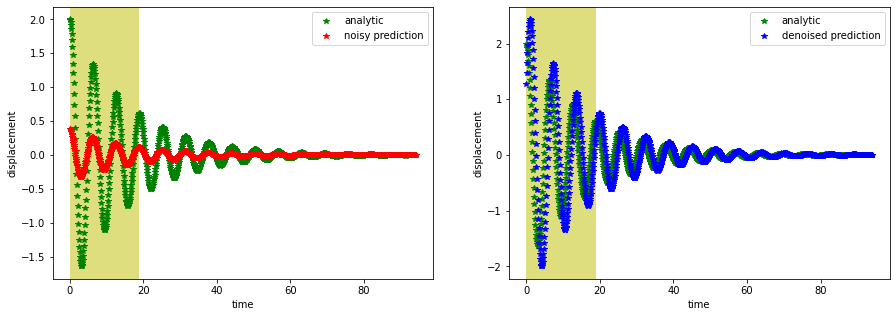

In [262]:
# adjust t to fit dimensions of predictions 
t_original = t
x_original = x_analytic

# Plots to show how well our parameters fit the data from the analytic solution
fig, axes = plt.subplots(1, 2, figsize = (15, 5))

# truncate t_original to match the length of x_pred_noisy and x_pred_denoised
t_original_trunc_noisy = t_original[:len(x_pred_noisy)]
t_original_trunc_denoised = t_original[:len(x_pred_denoised)]

axes[0].plot(t_original_trunc_noisy, x_original[:len(x_pred_noisy)], '*', color = 'green', label = 'analytic')
axes[0].plot(t_original_trunc_noisy, x_pred_noisy, '*', color = 'red', label = 'noisy prediction')

axes[1].plot(t_original_trunc_denoised, x_original[:len(x_pred_denoised)], '*', color = 'green', label = 'analytic')
axes[1].plot(t_original_trunc_denoised, x_pred_denoised, '*', color = 'blue', label = 'denoised prediction')

axes[0].legend()
axes[1].legend()

# This shades the seen part (in creating the model -yellow), but the model
# extends to the unseen white part
axes[0].axvspan(0, t[len_t], color='y', alpha=0.5, lw=0)
axes[1].axvspan(0, t[len_t], color='y', alpha=0.5, lw=0)

axes[0].set_xlabel('time')
axes[0].set_ylabel('displacement')
axes[1].set_xlabel('time')
axes[1].set_ylabel('displacement')

plt.show()

>>**(c)** How do these two plots compare? On the same graph, plot the relative errors to compare how x_pred noisy and x_pred_denoised differ from x_original (if necessary, use a logarithmic scale). $$ RE(true, pred) =|true -pred|/|true|$$ What conclusion do you get from the relative errors?

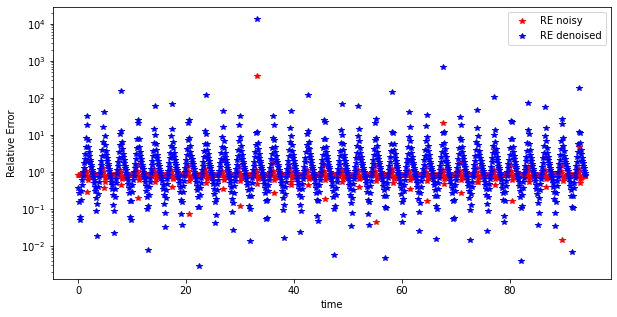

In [264]:
# Plots here
# calculate relative errors for noisy and denoised predictions
re_noisy = np.abs(x_original[:len(x_pred_noisy)] - x_pred_noisy) / np.abs(x_original[:len(x_pred_noisy)])
re_denoised = np.abs(x_original[:len(x_pred_denoised)] - x_pred_denoised) / np.abs(x_original[:len(x_pred_denoised)])

# plot relative errors
plt.figure(figsize=(10, 5))
plt.plot(t_original[:len(x_pred_noisy)], re_noisy, '*', color='red', label='RE noisy')
plt.plot(t_original[:len(x_pred_denoised)], re_denoised, '*', color='blue', label='RE denoised')
plt.yscale('log')  # use logarithmic scale due to the wide range of errors
plt.xlabel('time')
plt.ylabel('Relative Error')
plt.legend()
plt.show()

In [265]:
# calculate average relative errors for noisy and denoised predictions
avg_re_noisy = np.mean(re_noisy)
avg_re_denoised = np.mean(re_denoised)

# print the average relative errors
print(f"Average relative error for noisy predictions: {avg_re_noisy}")
print(f"Average relative error for denoised predictions: {avg_re_denoised}")

Average relative error for noisy predictions: 1.2434258610572073
Average relative error for denoised predictions: 17.762244632954847


The relative error has a lower variance. The relative errors for both are fairly small, but not great. Overall, I think  the RE denoised predictions have a *higher* relative error on average, and a higher variance. This is likely because the denoised model removed information, preventing overfitting and making the model more interpretable but reducing accuracy.

>>**(d)** In real-world scenarios, we often dont have x_analytic but only the noisy sample. How would you ensure if 
the parameters you obtained are good enough if you only have x_noisy?

In real-world scenarios, we often only have access to noisy data, and we don't have the true analytic functions. To ensure the parameters obtained are good enough, we can use:

1. **Cross-validation**: Split the noisy data into a training and validation set. Train the model on the training set and evaluate it on the validation set. The performance on the validation set is an unbiased estimate of the model's performance on unseen data.

2. **Residual Analysis**: Analyze the residuals, differences between the observed and predicted values. If the model fits, residuals should be randomly distributed around zero. Any pattern suggests the model isn't capturing some aspect of the data.

3. **Confidence Intervals**: Compute confidence intervals for the parameters. If a parameter's confidence interval includes zero, the parameter may not be meaningful.

4. **Sensitivity Analysis**: Perturb your input data slightly and observe how much the parameters change. If they change significantly, the model may be overfitting to the noise. 